In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
imsize=512
loader=transforms.Compose([transforms.Resize(imsize),transforms.ToTensor()])
stan=(260,235)
def image_loader(image_name):
    
    image=Image.open(image_name)
    image=image.resize(stan,Image.ANTIALIAS)
    image=loader(image).unsqueeze(0)
    return image.to(device,torch.float)

In [3]:
style_img=image_loader("picasso.jpg")
content_img=image_loader("dancing.jpg")
#assert style_img.size() == content_img.size()

In [4]:
class ContentLoss(nn.Module):
    def __init__(self,target):
        super(ContentLoss,self).__init__()
        self.target=target.detach()
    def forward(self,x):
        self.loss=F.mse_loss(x,self.target)
        return x

    

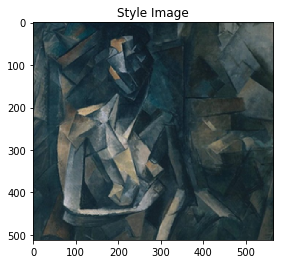

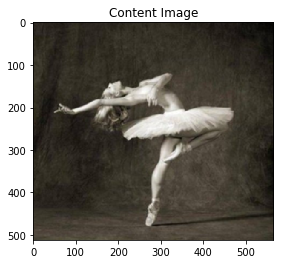

In [5]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')



In [6]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [7]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


In [8]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [9]:
content_layers_default = ['conv_3','conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn,normalization_mean,normalization_std,style_img,content_img,content_layers=content_layers_default,style_layers=style_layers_default):
    cnn=copy.deepcopy(cnn)
    content_losses=[]
    style_losses=[]
    norm=Normalization(normalization_mean,normalization_std).to(device)
    model=nn.Sequential(norm)
    i=0
    for layer in cnn.children():
        if isinstance(layer,nn.Conv2d):
            i=i+1
            name='conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        model.add_module(name,layer)
        
        if name in content_layers:
            target=model(content_img).detach()
            content_loss=ContentLoss(target)
            model.add_module("content_loss{}".format(i),content_loss)
            content_losses.append(content_loss)
        if name in style_layers:
            target=model(style_img).detach()
            style_loss=StyleLoss(target)
            model.add_module("style_loss{}".format(i),style_loss)
            style_losses.append(style_loss)
    
    for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

    
     
            
        
    model = model[:(i + 1)]

    return model, style_losses, content_losses       

In [10]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer



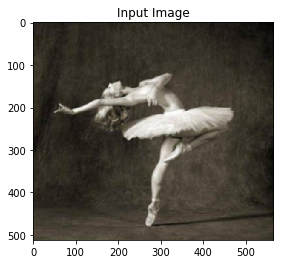

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 4.396322 Content Loss: 3.196901

run [100]:
Style Loss : 1.269472 Content Loss: 2.185460

run [150]:
Style Loss : 0.786163 Content Loss: 1.920264

run [200]:
Style Loss : 0.510928 Content Loss: 1.824080

run [250]:
Style Loss : 0.363367 Content Loss: 1.767663

run [300]:
Style Loss : 0.277665 Content Loss: 1.730070

run [350]:
Style Loss : 0.224622 Content Loss: 1.700757

run [400]:
Style Loss : 0.195337 Content Loss: 1.678655

run [450]:
Style Loss : 0.176502 Content Loss: 1.661772

run [500]:
Style Loss : 0.166218 Content Loss: 1.649044

run [550]:
Style Loss : 0.159764 Content Loss: 1.638514

run [600]:
Style Loss : 0.155827 Content Loss: 1.630666

run [650]:
Style Loss : 0.152777 Content Loss: 1.624352

run [700]:
Style Loss : 0.151143 Content Loss: 1.619264

run [750]:
Style Loss : 0.149567 Content Loss: 1.615105

run [800]:
Style Loss : 0.148514 Content Loss: 1.611188

run [850]:
Style Loss : 0.147793 Content

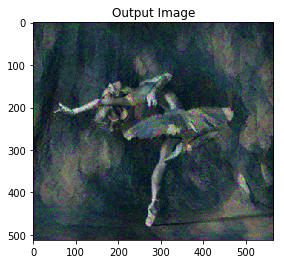

In [11]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=3000,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img
input_img = content_img.clone()
#input_img = torch.randn(content_img.data.size(), device=device)
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()